In [90]:
!pip install yfinance
#!pip install tensorflow
#!pip install --quiet yfinance tensorflow transformers accelerate torch

In [91]:
# Install necessary libraries
#!pip install transformers
#!pip install torch
#!pip install transformers accelerate torch safetensors
#!pip install transformers torch scikit-learn numpy matplotlib


In [92]:
import yfinance as yf
import datetime

# Define the ticker symbol for TCS
ticker_symbol = "TCS.NS" # .NS for NSE listed stock

# Define the start and end dates
start_date = datetime.datetime(2015, 1, 1)
#end_date = datetime.datetime(2025,7,1)
end_date = datetime.datetime.now()

# Fetch the data
tcs = yf.download(ticker_symbol, start=start_date, end=end_date)

# Print the first few rows of the DataFrame
print(tcs.head())

# Print the last few rows of the DataFrame
print(tcs.tail())

/tmp/ipython-input-92-3877810530.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  tcs = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open   Volume
Ticker           TCS.NS       TCS.NS       TCS.NS       TCS.NS   TCS.NS
Date                                                                   
2015-01-01  1041.739990  1050.518161  1039.877930  1050.518161   366830
2015-01-02  1055.612793  1060.319047  1043.806294  1043.969949   925740
2015-01-05  1039.570679  1063.981776  1033.186502  1056.247189  1754242
2015-01-06  1001.245483  1035.007745   998.544463  1035.007745  2423784
2015-01-07   989.418152  1014.565895   985.223448  1010.821394  2636332
Price             Close         High          Low         Open   Volume
Ticker           TCS.NS       TCS.NS       TCS.NS       TCS.NS   TCS.NS
Date                                                                   
2025-06-30  3462.000000  3464.899902  3430.000000  3439.899902  1468351
2025-07-01  3429.699951  3485.000000  3413.500000  3455.000000  2375183
2025-07-02  3423.300049  3489.899902  3420.000000  3487.199951  

In [93]:
tcs.head()

Price,Close,High,Low,Open,Volume
Ticker,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS
Date,,,,,
2015-01-01,1041.739990,1050.518161,1039.877930,1050.518161,366830
2015-01-02,1055.612793,1060.319047,1043.806294,1043.969949,925740
2015-01-05,1039.570679,1063.981776,1033.186502,1056.247189,1754242
2015-01-06,1001.245483,1035.007745,998.544463,1035.007745,2423784
2015-01-07,989.418152,1014.565895,985.223448,1010.821394,2636332


In [94]:
tcs.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2594 entries, 2015-01-01 to 2025-07-04
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (Close, TCS.NS)   2594 non-null   float64
 1   (High, TCS.NS)    2594 non-null   float64
 2   (Low, TCS.NS)     2594 non-null   float64
 3   (Open, TCS.NS)    2594 non-null   float64
 4   (Volume, TCS.NS)  2594 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 121.6 KB


 Data preparation for training an LSTM model.

In [95]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# For LSTM, the 'Close' price is used is used for normalisation.

data_to_normalize = tcs[['Close']].values # .values gets the numpy array

# Initialize the MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_to_normalize)

# For time series prediction, a common approach is to use a sequence of past data points to predict the next data point.
# Let's define a lookback period (time steps).
lookback = 60

X_data = []
y_data = []

for i in range(lookback, len(scaled_data)):
    X_data.append(scaled_data[i-lookback:i, 0]) # Sequence of 'lookback' data points
    y_data.append(scaled_data[i, 0]) # The next data point

# Convert the lists to numpy arrays
X_data, y_data = np.array(X_data), np.array(y_data)

# Reshape X_data for LSTM input: [samples, time steps, features]
X_data = np.reshape(X_data, (X_data.shape[0], X_data.shape[1], 1)) # Here, features is 1 because we are using only the 'Close' price.

print("Shape of normalized and formatted X_data:", X_data.shape)
print("Shape of normalized and formatted y_data:", y_data.shape)


Shape of normalized and formatted X_data: (2534, 60, 1)
Shape of normalized and formatted y_data: (2534,)


In [96]:
# Split the data into training and testing sets
train_size = int(len(X_data) * 0.8) # 80% for training, 20% for testing
X_train, X_test = X_data[:train_size], X_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (2027, 60, 1)
Shape of X_test: (507, 60, 1)
Shape of y_train: (2027,)
Shape of y_test: (507,)


Build and Train LSTM with 32 epoach

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2)) # Adding dropout to prevent overfitting

model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=25))
model.add(Dense(units=1)) # Output layer predicting the next price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
epochs = 32  # Define the number of epochs
batch_size = 32 # Define the batch size

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1,shuffle=False) # Using 10% of training data for validation

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/32
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 155ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 2/32
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - loss: 0.0108 - val_loss: 0.0043
Epoch 3/32
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - loss: 0.0234 - val_loss: 0.0013
Epoch 4/32
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 0.0298 - val_loss: 7.5323e-04
Epoch 5/32
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - loss: 0.0297 - val_loss: 0.0011
Epoch 6/32
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - loss: 0.0138 - val_loss: 9.5149e-04
Epoch 7/32
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - loss: 0.0044 - val_loss: 6.5808e-04
Epoch 8/32
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 9/32
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0019 - val_loss: 0.0114
Epoch 10/32
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.0014 - val_loss: 0.0142
Epoch 11/32
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0810 - val_loss: 0.0016
Epoch 12/32
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s

Predict and Plot

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Shape of predictions: (507, 1)
Shape of actual_prices: (507, 1)
Length of test_dates: 507
Length of actual_prices: 507
Length of predictions: 507


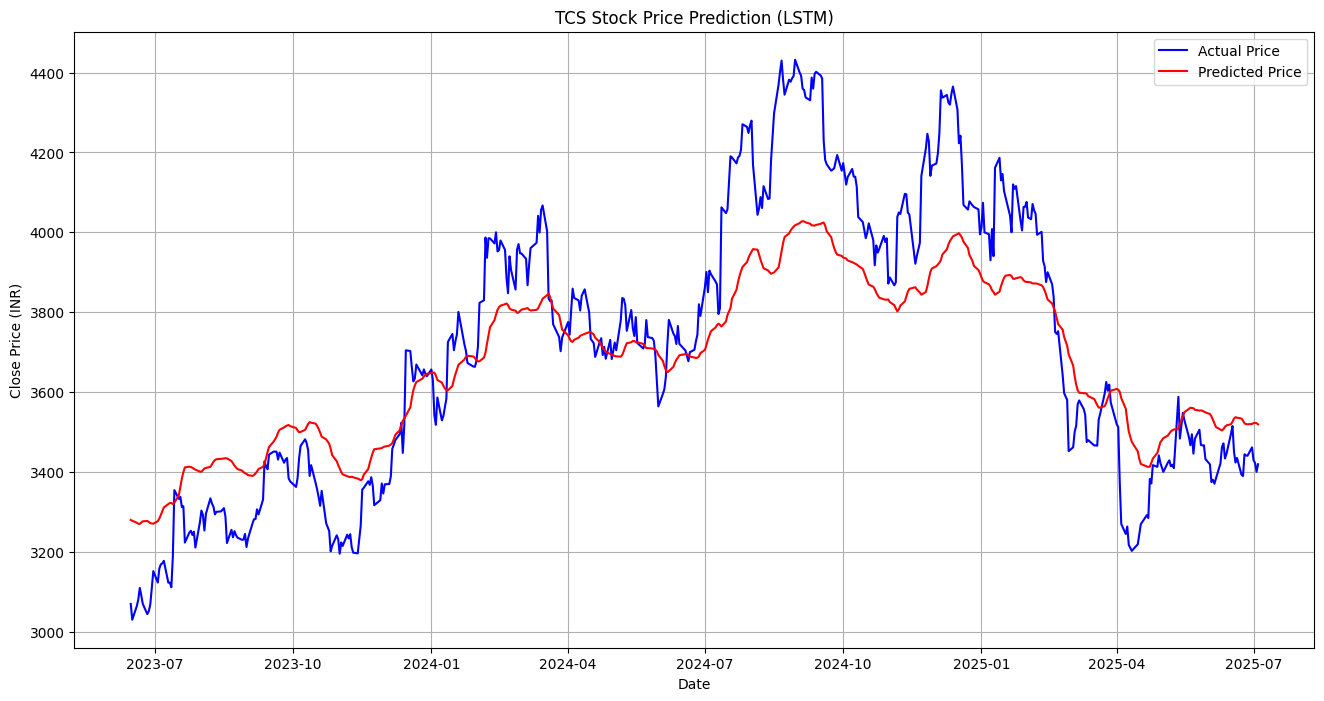

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step

Predicted price for the day after the last test date: 3517.49 INR

Predicted prices for the next 30 days:
Day 1: 3517.49 INR
Day 2: 3523.30 INR
Day 3: 3532.17 INR
Day 4: 3542.01 INR
Day 5: 3551.82 INR
Day 6: 3561.17 INR
Day 7: 3569.87 INR
Day 8: 3577.87 INR
Day 9: 3585.20 INR
Day 10: 3591.87 INR
Day 11: 3597.94 INR
Day 12: 3603.46 INR
Day 13: 3608.47 INR
Day 14: 3613.02 INR
Day 15: 3617.14 INR
Day 16: 3620.89 INR
Day 17: 3624.29 INR
Day 18: 3627.38 INR
Day 19: 3630.18 INR
Day 20: 3632.72 INR
Day 21: 3635.03 INR
Day 22: 3637.12 INR
Day 23: 3639.02 INR
Day 24: 3640.75 INR
Day 25: 3642.31 INR
Day 26: 3643.73 INR
Day 27: 3645.02 INR
Day 28: 3646.19 INR
Day 29: 3647.25 INR
Day 30: 3648.21 INR


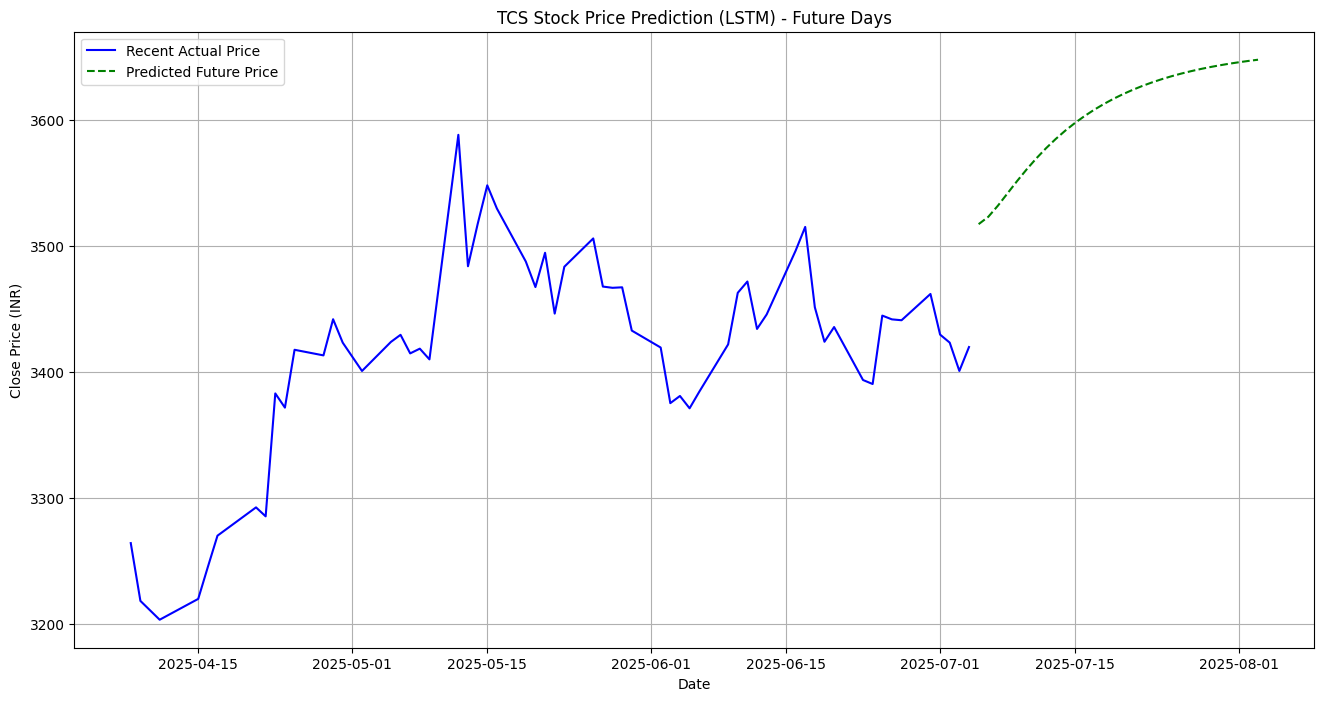

In [98]:
import numpy as np

predictions = model.predict(X_test)

# Since the predictions were made on scaled data, we need to inverse transform them
# to get the predicted prices in the original scale.
# We need to use the same scaler that was fitted to the 'Close' prices.
predictions = scaler.inverse_transform(predictions)

# The actual test prices inverse transformed for comparison
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

print("Shape of predictions:", predictions.shape)
print("Shape of actual_prices:", actual_prices.shape)

#  the actual prices vs predicted prices to visualize the model's performance.
import matplotlib.pyplot as plt

# Find the starting index in the original tcs dataframe for the test set data points (y_test)
start_index_test_data = train_size + lookback

# Get the dates from the original tcs index that correspond to the test set
test_dates = tcs.index[start_index_test_data:]

print("Length of test_dates:", len(test_dates))
print("Length of actual_prices:", len(actual_prices))
print("Length of predictions:", len(predictions))

# Plot the results
plt.figure(figsize=(16, 8))
plt.title('TCS Stock Price Prediction (LSTM)')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')
plt.plot(test_dates, actual_prices, label='Actual Price', color='blue')
plt.plot(test_dates, predictions, label='Predicted Price', color='red')
plt.legend()
plt.grid(True)
plt.show()

# Sequential prediction or multi-step forecasting.

# Let's predict the price for the next day immediately following the test set's last date.

# Get the last 'lookback' data points from the *entire* scaled dataset
last_lookback_sequence = scaled_data[-lookback:].reshape(1, lookback, 1)

# Predict the next price using the model
next_day_scaled_prediction = model.predict(last_lookback_sequence)

# Inverse transform the prediction
next_day_price_prediction = scaler.inverse_transform(next_day_scaled_prediction)

print(f"\nPredicted price for the day after the last test date: {next_day_price_prediction[0][0]:.2f} INR")

# If you want to predict multiple future days, you would iteratively take the last 'lookback' predicted/actual values to predict the next one.

def predict_future_days(model, initial_sequence, scaler, num_days):
    """
    Predicts future stock prices for a specified number of days.

    Args:
        model: The trained Keras model.
        initial_sequence: The last 'lookback' sequence of scaled data
                          to start predictions from (shape: [1, lookback, 1]).
        scaler: The fitted MinMaxScaler.
        num_days: The number of future days to predict.

    Returns:
        A list of predicted future prices in original scale.
    """
    current_sequence = initial_sequence.copy()
    future_predictions = []

    for _ in range(num_days):
        # Predict the next value
        next_scaled_prediction = model.predict(current_sequence, verbose=0)

        # Inverse transform the prediction
        next_price_prediction = scaler.inverse_transform(next_scaled_prediction)
        future_predictions.append(next_price_prediction[0][0])

        # Update the sequence: remove the oldest data point and add the new prediction
        # The sequence needs to be in the scaled format for the model input
        next_scaled_value = next_scaled_prediction.reshape(1, 1, 1) # Reshape to [1, 1, 1] for appending
        current_sequence = np.append(current_sequence[:, 1:, :], next_scaled_value, axis=1)


    return future_predictions

# Number of future days to predict
num_future_days = 30 # Example: Predict the next 30 days

# Get the initial sequence (last 'lookback' days from the original data)
initial_sequence_for_future = scaled_data[-lookback:].reshape(1, lookback, 1)

# Predict the next 'num_future_days'
future_predicted_prices = predict_future_days(model, initial_sequence_for_future, scaler, num_future_days)

print(f"\nPredicted prices for the next {num_future_days} days:")
for i, price in enumerate(future_predicted_prices):
    print(f"Day {i+1}: {price:.2f} INR")

# You can also plot these future predictions
# Get the dates for future predictions
last_date_in_data = tcs.index[-1]
future_dates = [last_date_in_data + datetime.timedelta(days=i) for i in range(1, num_future_days + 1)]

plt.figure(figsize=(16, 8))
plt.title('TCS Stock Price Prediction (LSTM) - Future Days')
plt.xlabel('Date')
plt.ylabel('Close Price (INR)')

# Plot the last part of the actual data for context
plt.plot(tcs.index[-lookback:], scaler.inverse_transform(scaled_data[-lookback:]), label='Recent Actual Price', color='blue')

# Plot the predicted future prices
plt.plot(future_dates, future_predicted_prices, label='Predicted Future Price', color='green', linestyle='--')

plt.legend()
plt.grid(True)
plt.show()

LLM-based Stock Analysis Summary

In [99]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
from transformers import pipeline, set_seed
from sklearn.metrics import accuracy_score, classification_report
import torch


In [100]:
# --- LLM-based Stock Analysis Summary using Falcon-1B-instruct ---

# Initialize a text generation pipeline with the Falcon-1B-instruct model
# Note: Loading larger models might require significant RAM/GPU resources.
# 'falcon-rw-1b-instruct' is a smaller Falcon model suitable for Colab Free Tier.
try:
    # Check if accelerate is installed for potentially faster loading
    from accelerate import Accelerator
    print("Accelerate is available.")
except ImportError:
    print("Accelerate not found. Model loading might be slower.")


print("Loading Falcon-1B-instruct model...")
try:
    # Using trust_remote_code=True is necessary for some models like Falcon
    generator_falcon = pipeline(
        'text-generation',
        model='tiiuae/falcon-rw-1b-instruct',
        torch_dtype=torch.bfloat16, # Use bfloat16 if supported for memory efficiency
        device_map="auto", # Automatically distributes the model layers
        trust_remote_code=True # Required for Falcon models
    )
    print("Falcon-1B-instruct model loaded successfully.")
except Exception as e:
    print(f"Error loading Falcon-1B-instruct model: {e}")
    print("Falling back to DistilGPT-2 for summary generation.")
    # Fallback to the previously used model if Falcon fails to load
    generator_falcon = pipeline('text-generation', model='distilgpt2')
    set_seed(42)
    print("DistilGPT-2 model loaded instead.")


def get_stock_summary_falcon(financial_news, quarterly_results_summary, prediction_insight):
    """
    Generates a summary of stock analysis using the Falcon-1B-instruct LLM.

    Args:
        financial_news (str): Recent financial news or relevant articles.
        quarterly_results_summary (str): A summary of the latest quarterly financial results.
        prediction_insight (str): An insight derived from the LSTM model's prediction.

    Returns:
        str: A generated summary from the LLM.
    """
    # Falcon-instruct uses a specific prompt format.
    # The instruction is typically followed by the context and the question.
    prompt = f"""
The following is financial information about TCS (Tata Consultancy Services). Analyze the recent financial news, the summary of the latest quarterly results, and an LSTM model's prediction insight. Based on this information, provide a concise summary of the current outlook for TCS stock, considering how the quarterly results and news might influence the predicted future price.

Recent Financial News:
{financial_news}

Latest Quarterly Results Summary:
{quarterly_results_summary}

LSTM Model Prediction Insight:
{prediction_insight}

Summary:
"""

    # Generate text using the Falcon LLM
    # Adjust max_new_tokens based on desired summary length.
    # Falcon-instruct generally doesn't require specifying num_return_sequences > 1 for single response.
    # We use do_sample=True for potentially more varied text, but set a seed for reproducibility if needed.
    set_seed(42) # Setting seed for generation
    generated_output = generator_falcon(
        prompt,
        max_new_tokens=250, # Control the length of the generated text
        do_sample=True,      # Use sampling
        top_k=10,            # Limit to top k tokens
        num_return_sequences=1,
        eos_token_id=generator_falcon.tokenizer.eos_token_id, # Stop generation at EOS token
        pad_token_id=generator_falcon.tokenizer.eos_token_id # Handle padding if needed
    )

    generated_text = generated_output[0]['generated_text']

    # The Falcon-instruct model should generate the summary directly after the "Summary:" line in the prompt.
    # We need to find where the prompt ends and the generated text begins.
    prompt_end_marker = "\nSummary:\n"
    prompt_end_index = generated_text.find(prompt_end_marker)

    if prompt_end_index != -1:
        # Extract the text that comes after the prompt_end_marker
        summary = generated_text[prompt_end_index + len(prompt_end_marker):].strip()
    else:
        # Fallback if the prompt structure wasn't found in the output (less likely with instruct models)
        summary = generated_text.strip()

    return summary

# --- Example Usage ---
# Use the placeholder data from the preceding code
sample_financial_news="TCS is announcing its Q1 FY26 results and interim dividend on July 10, while also implementing a new bench policy that requires employees to be billed for at least 225 days annually, aiming to increase utilization and upskilling."
sample_quarterly_results_summary="TCS's last quarter (Q4 FY25) saw a slight net profit decline despite revenue growth, with strong deal wins but management highlighting client decision delays. For Q1 FY26 (due July 10), analysts predict a subdued performance for TCS and the broader IT sector, expecting flat to slightly negative revenue growth due to ongoing global macroeconomic uncertainties and cautious client spending."
sample_prediction_insight="the LSTM model predicts a gradual upward trend in TCS stock price over the next 30 days based on historical price data."

# Get the summary using the Falcon LLM
print("\n--- LLM (Falcon-1B-instruct) Generated Stock Analysis Summary ---")
try:
    stock_summary_falcon = get_stock_summary_falcon(sample_financial_news, sample_quarterly_results_summary, sample_prediction_insight)
    print(stock_summary_falcon)
except Exception as e:
    print(f"An error occurred during summary generation: {e}")
    print("Please check if the model loaded correctly and if resources are sufficient.")

Accelerate is available.
Loading Falcon-1B-instruct model...
Error loading Falcon-1B-instruct model: tiiuae/falcon-rw-1b-instruct is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`
Falling back to DistilGPT-2 for summary generation.


Device set to use cpu


DistilGPT-2 model loaded instead.

--- LLM (Falcon-1B-instruct) Generated Stock Analysis Summary ---
TCS shares have gained a substantial gain in the past year, with the company expected to gain a significant amount of capital and capital gains in the past 10 days.
TCS shares have gained a significant amount of capital and capital gains in the past 10 days as a result of the company's recent announcement that it will be expanding its existing business and expanding its existing business with a new focus on customer growth.
The company has announced a new strategy of offering an increased share of shares of TCS stock, while also expanding its existing business with a new focus on customer growth.
TCTS shares have gained a substantial amount of capital and capital gains in the past 10 days based on historical price data.
In Q4 FY26, investors were expecting a strong return on their investment in the company.
The company has announced a new strategy of offering an increased share of share

News Sentiment Classification using DistilBERT SST-2

In [101]:
# DistilBERT fine-tuned on the SST-2 dataset is designed for binary sentiment analysis (positive/negative).

# Load the sentiment analysis pipeline using the SST-2 fine-tuned model
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

# Example stock-related news headlines (replace with actual headlines)
news_headlines = [
    "TCS reports strong quarterly earnings, stock price jumps.", # Should be Positive
    "Analysts are concerned about the future growth of the tech sector.", # Should be Negative
    "TCS announces new partnership, market optimistic.", # Should be Positive
    "Global economic slowdown impacts IT spending.", # Should be Negative
    "TCS stock price remains stable despite market volatility.", # Should be Neutral (but SST-2 is binary)
    "Company faces lawsuit, shares decline." # Should be Negative
]

print("\n--- DistilBERT SST-2 News Sentiment Classification ---")
for headline in news_headlines:
    result = sentiment_analyzer(headline)
    sentiment = result[0]['label']
    score = result[0]['score']
    print(f"Headline: '{headline}'")
    print(f"Sentiment: {sentiment} (Score: {score:.4f})")
    print("-" * 20)

# Sentiment of the generated LSTM summary text
summary_sentiment = sentiment_analyzer(stock_summary_falcon)
print(f"\nSentiment of the generated LSTM summary: {summary_sentiment[0]['label']} (Score: {summary_sentiment[0]['score']:.4f})")

Device set to use cpu



--- DistilBERT SST-2 News Sentiment Classification ---
Headline: 'TCS reports strong quarterly earnings, stock price jumps.'
Sentiment: POSITIVE (Score: 0.9986)
--------------------
Headline: 'Analysts are concerned about the future growth of the tech sector.'
Sentiment: POSITIVE (Score: 0.9942)
--------------------
Headline: 'TCS announces new partnership, market optimistic.'
Sentiment: POSITIVE (Score: 0.9954)
--------------------
Headline: 'Global economic slowdown impacts IT spending.'
Sentiment: NEGATIVE (Score: 0.6926)
--------------------
Headline: 'TCS stock price remains stable despite market volatility.'
Sentiment: POSITIVE (Score: 0.9975)
--------------------
Headline: 'Company faces lawsuit, shares decline.'
Sentiment: NEGATIVE (Score: 0.9983)
--------------------

Sentiment of the generated LSTM summary: POSITIVE (Score: 0.9851)
